# PyTorch Workflow

Lets explore end-to-end workflow.

In [73]:
what_were_coverting = {
    1: "data (prepare and load)", 2: "build model",
    3: " training (fitting the model to data)",
    4: "making predictions and evaluating a model (inference)",
    5: "saving and loading",
    6: "putting it all together"
}

In [74]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.4.0'

## 1. Data preparing and loading

* Excel
* Images
* Videos
* Audio
* Text

To showcase this, let's create some *known* data using the linear regression formula.


In [75]:
# Secret params the model has to learn
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias # the formula is a black box
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [76]:
len(X), len(y)

(50, 50)

### Splitting data into training and test sets

One of the really important concepts

(40, 10)

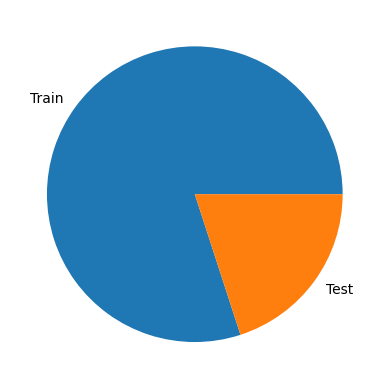

In [77]:
# Create a train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

fig, ax = plt.subplots()
ax.pie([len(X_train), len(X_test)], labels=["Train", "Test"])
len(X_train), len(X_test)

How might we better visualize our data?

In [78]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="y", s=4, label="Testing data")

  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  plt.legend(prop={"size": 14})


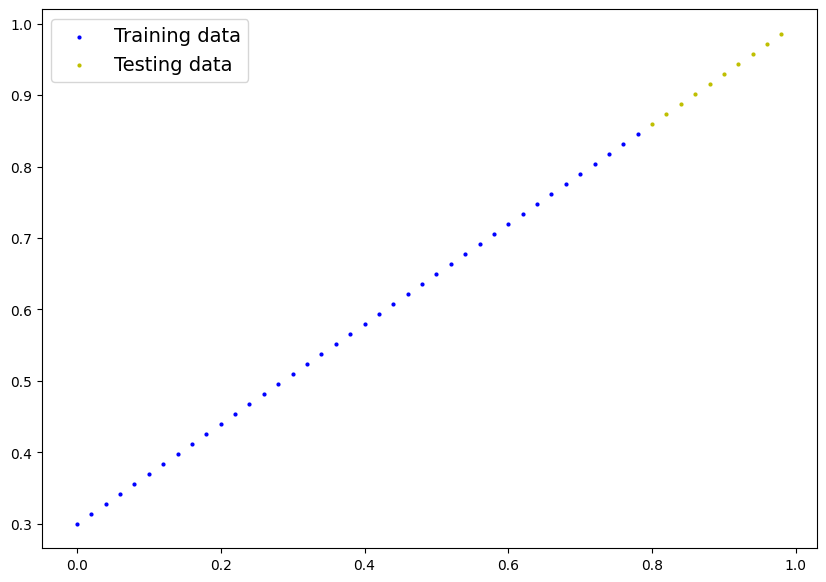

In [79]:
plot_predictions()

## Build model

Our first PyTorch model!

In [80]:
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weight = nn.Parameter(torch.randn(1, dtype=torch.float32, requires_grad=True))
    self.bias = nn.Parameter(torch.randn(1, dtype=torch.float32, requires_grad=True))

  def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data
    return self.weight * x + self.bias

### PyTorch model building essentials

* torch.nn - building blocks of computational graphs
* torch.nn.Parameter - What parameter should our model try to learn, often .nn models will set this for us
* torch.nn.Module - base class for all neural network modules
* torch.optim - Optimises parameters, helps with gradient descent
* def forward() - All module subclasses must implement moving from one step to the next

## Checking the contents of PyTorch Model

Now that we have a model, lets see what is inside...
Checking the results with `.parameters()`

In [81]:
# Create a random seed

torch.manual_seed(42)

# Create an instance

model_0 = LinearRegressionModel()

list(model_0.parameters()), model_0.state_dict()

([Parameter containing:
  tensor([0.3367], requires_grad=True),
  Parameter containing:
  tensor([0.1288], requires_grad=True)],
 OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))]))

## Making predictions using `torch.inference_mode()`

To check the predictive power, let's see how well it predicts `y_test` based on `X_test`

In [82]:
# Make predictions (faster version over none/.no_grad())
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds, y_test

(tensor([[0.3982],
         [0.4049],
         [0.4116],
         [0.4184],
         [0.4251],
         [0.4318],
         [0.4386],
         [0.4453],
         [0.4520],
         [0.4588]]),
 tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160],
         [0.9300],
         [0.9440],
         [0.9580],
         [0.9720],
         [0.9860]]))

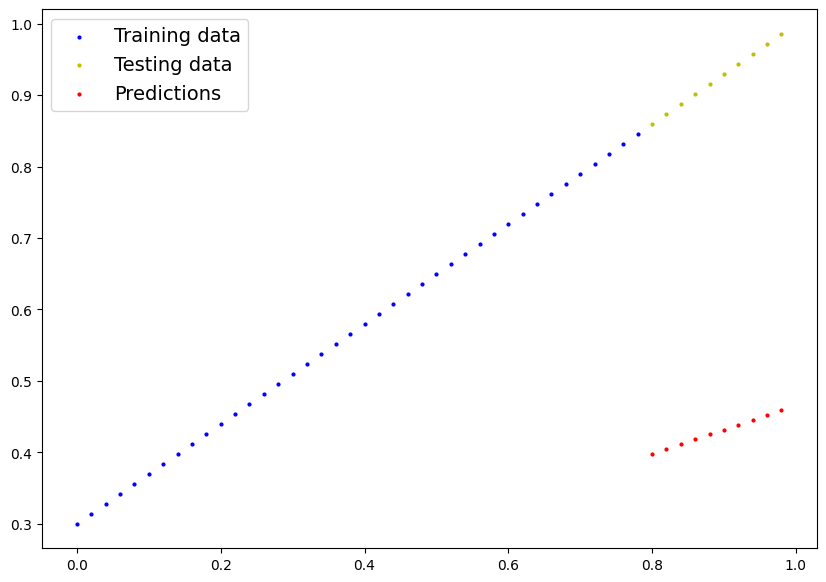

In [83]:
plot_predictions(predictions=y_preds)

## 3. Train model

The idea of training is to move unknown params towards a solution. In other words to go from a poor solution to a better.

One way to measure how wrong the predictions are is to use a loss function(criterion / cost function).


In [84]:
list(model_0.parameters()), model_0.state_dict()

([Parameter containing:
  tensor([0.3367], requires_grad=True),
  Parameter containing:
  tensor([0.1288], requires_grad=True)],
 OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))]))

Let's create a loss function and an optimizer we can use to help improve our model.

Depending on what kind of problem you're working on will depend on what loss function and what optimizer you use.

However, there are some common values, that are known to work well such as the SGD (stochastic gradient descent) or Adam optimizer. And the MAE (mean absolute error) loss function for regression problems (predicting a number) or binary cross entropy loss function for classification problems (predicting one thing or another).

For our problem, since we're predicting a number, let's use MAE (which is under torch.nn.L1Loss()) in PyTorch as our loss function.

 for more see: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/01_pytorch_workflow.ipynb

In [85]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer
optimiser = torch.optim.SGD(model_0.parameters(), lr=0.01) # lr = learning rate hyperparameter

### Building a Training loop

Things needed:
0. Loop through the data
1. Forward pass
2. Calculate loss
3. Optimiser zero grad
4. Loss backward - move backwards through net to calc gradiants vs loss
5. Optimiser step to improve the loss

In [86]:
# Tracking Experiments
epoch_count = []
loss_values = []
test_loss_values = []


In [87]:
# An epoch is one run through the data loop
epochs = 200

for epoch in range(epochs):

  # Training

  model_0.train() # Apply gradient requirements to model

  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Calculate a loss
  loss = loss_fn(y_pred, y_train)
  # print(f"Loss: {loss}")

  # 3. Optimiser zero grad
  optimiser.zero_grad()

  # 4. Perform back propagation on the loss with respect to the model parameters
  loss.backward()

  # 5. Gradient descent / Optimizer step
  optimiser.step()  # default way to accumulate the changes done in response to the loss

  # Testing Loop

  model_0.eval() # Turns off gradient tracking etc, speeds up eval/testing
  with torch.inference_mode():
    # 1. Forward pass
    test_pred = model_0(X_test)

    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)

  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
    print(model_0.state_dict())

Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
OrderedDict([('weight', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
OrderedDict([('weight', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
OrderedDict([('weight', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
OrderedDict([('weight', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
OrderedDict([('weight', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
OrderedDict([('weight', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
OrderedDict([('weight', tensor([0.5116])), ('bias', tensor([0.3788]))])
E

Manually run the loop to see how the loss decreases.
Then see how you are doing with the params representation

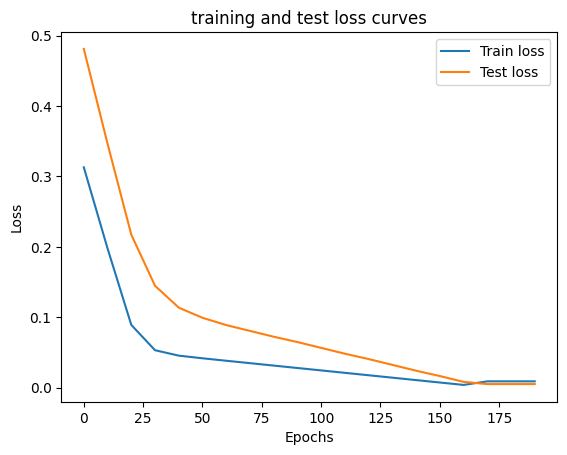

In [88]:
import numpy as np
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [89]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)
y_preds_new, y_test

(tensor([[0.8685],
         [0.8825],
         [0.8965],
         [0.9105],
         [0.9245],
         [0.9384],
         [0.9524],
         [0.9664],
         [0.9804],
         [0.9944]]),
 tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160],
         [0.9300],
         [0.9440],
         [0.9580],
         [0.9720],
         [0.9860]]))

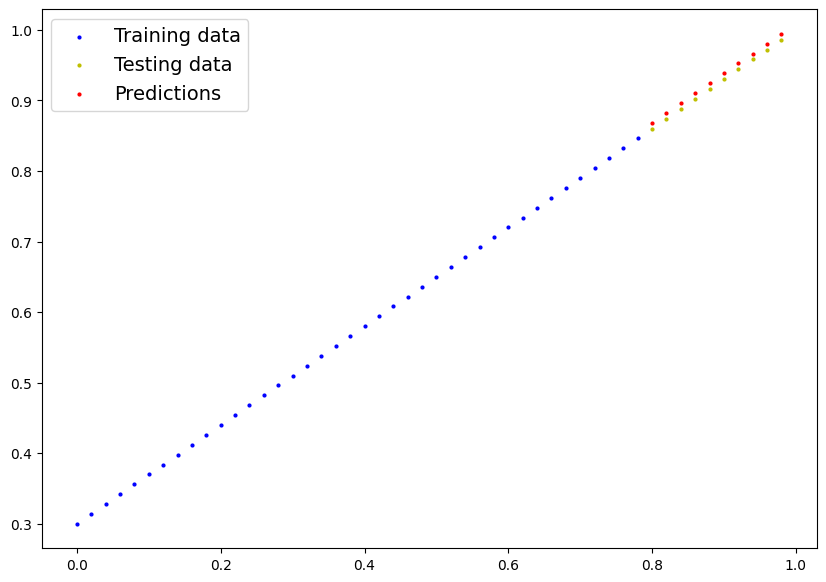

In [90]:
plot_predictions(predictions=y_preds_new)

## Saving a Model in PyTorch

Three methods to know about:

1. `torch.save()` - saves as a ZIP
2. `torch.load()` - loads a saved model from pickle or ZIP
3. `torch.jit.load(path)`
4. `torch.nn.Module.load_state_dict(path, weights_only)`

Using `torch.jit.script(model)` will allow you to save a full model as .pt file that can be loaded with the jit.

... jit, Executorch ...

In [91]:
from pathlib import Path

# Create models directory
MODEL_HOME = Path("models")
MODEL_HOME.mkdir(parents=True, exist_ok=True)

# Create a model save path
MODEL_NAME = "01_pytorch_linear.pth"
MODEL_SAVE_PATH = MODEL_HOME / MODEL_NAME
MODEL_SAVE_PATH


PosixPath('models/01_pytorch_linear.pth')

In [92]:
torch.save(model_0.state_dict(), MODEL_SAVE_PATH)

In [93]:
!ls -l models

total 8
-rw-r--r--  1 henrikvendelbo  staff  1556 Oct 27 19:32 01_pytorch_linear.pth


### Loading a PyTorch Model

Since we saved the state_dict for the model ratehr than the entire, we will create a new instance and load the saved state_dict into that.a

In [94]:
model_0.state_dict()

OrderedDict([('weight', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [95]:
loaded_model_0 = LinearRegressionModel()
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH, weights_only=True))
loaded_model_0.state_dict()

OrderedDict([('weight', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [96]:
# Make some predictions
model_0.eval()
loaded_model_0.eval()
with torch.inference_mode():
  y_preds = model_0(X_test)
  loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [97]:
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## 6. Putting it all together

Let's recap

In [98]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.4.0'

Device agnostic code

Use MLS/CUDA if available

In [99]:
# Setup device agnostic code ...

### 6.1 Data

In [100]:
# Create a line that the models should guess
weight2 = 0.7
bias2 = 0.1

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight2 * X + bias2
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.1000],
         [0.1140],
         [0.1280],
         [0.1420],
         [0.1560],
         [0.1700],
         [0.1840],
         [0.1980],
         [0.2120],
         [0.2260]]))

In [101]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

## 6.2 Building a PyTorch Linear Model

Simple Linear Regression Model



In [102]:
import torch
from torch import nn

class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()

        # use nn.Linear to create a linear layer
        self.linear_layer = nn.Linear(in_features=1, out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor: 
        return self.linear_layer(x)

# Predicatable results with manual seed
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [103]:
X_train[:10], y_train[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.1000],
         [0.1140],
         [0.1280],
         [0.1420],
         [0.1560],
         [0.1700],
         [0.1840],
         [0.1980],
         [0.2120],
         [0.2260]]))

In [104]:
next(model_1.parameters()).device  

device(type='cpu')

In [105]:
# Set the model to use the target device
device = "cpu"
if torch.backends.mps.is_available and False:
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")

model_1.to(device)
next(model_1.parameters()).device, next(model_1.parameters()).type()

(device(type='cpu'), 'torch.FloatTensor')

### 6.3 Training

For training we need:

* Loss function
* Optimizer
* Training loop
* Testing loop

In [106]:
# Setup loss function and optimizer
loss_fn = nn.L1Loss() # same as Mean Absolute Error

# Setup an optimizer|
optimiser = torch.optim.SGD(model_1.parameters(), lr=0.01)


In [107]:
torch.manual_seed(42)

epochs = 200

# Put data on the target device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    model_1.train()

    # 1. Forward pass
    y_pred = model_1(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)

    # 3. Zero the gradients
    optimiser.zero_grad()

    # 4. Backward propagation
    loss.backward()

    # 5. Optimizer step
    optimiser.step()

    ### Evaluation
    model_1.eval()

    # 1. Forward pass
    with torch.inference_mode():
        test_pred = model_1(X_test)

        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    # Printing
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")


Epoch: 0 | Loss: 0.7551778554916382 | Test loss: 0.77397620677948
Epoch: 10 | Loss: 0.6399680376052856 | Test loss: 0.6392663717269897
Epoch: 20 | Loss: 0.5247582197189331 | Test loss: 0.5045565366744995
Epoch: 30 | Loss: 0.409548282623291 | Test loss: 0.36984673142433167
Epoch: 40 | Loss: 0.2943384647369385 | Test loss: 0.23513686656951904
Epoch: 50 | Loss: 0.17912858724594116 | Test loss: 0.1004270538687706
Epoch: 60 | Loss: 0.06402723491191864 | Test loss: 0.03343570977449417
Epoch: 70 | Loss: 0.03615035116672516 | Test loss: 0.0744357705116272
Epoch: 80 | Loss: 0.0322178453207016 | Test loss: 0.07306783646345139
Epoch: 90 | Loss: 0.028742367401719093 | Test loss: 0.06616915762424469
Epoch: 100 | Loss: 0.025311116129159927 | Test loss: 0.058583587408065796
Epoch: 110 | Loss: 0.021877549588680267 | Test loss: 0.05031111091375351
Epoch: 120 | Loss: 0.018438735976815224 | Test loss: 0.042038630694150925
Epoch: 130 | Loss: 0.015009166672825813 | Test loss: 0.034453026950359344
Epoch: 14

In [113]:
from pathlib import Path

MODEL_HOME = Path("models")
MODEL_HOME.mkdir(parents=True, exist_ok=True)

torch.save(model_1.state_dict(), MODEL_HOME / "02_pytorch_linear.pth")
model_1.state_dict(), MODEL_HOME

(OrderedDict([('linear_layer.weight', tensor([[0.6919]])),
              ('linear_layer.bias', tensor([0.0995]))]),
 PosixPath('models'))

In [112]:
weight, bias, weight2, bias2

(0.7, 0.3, 0.7, 0.1)

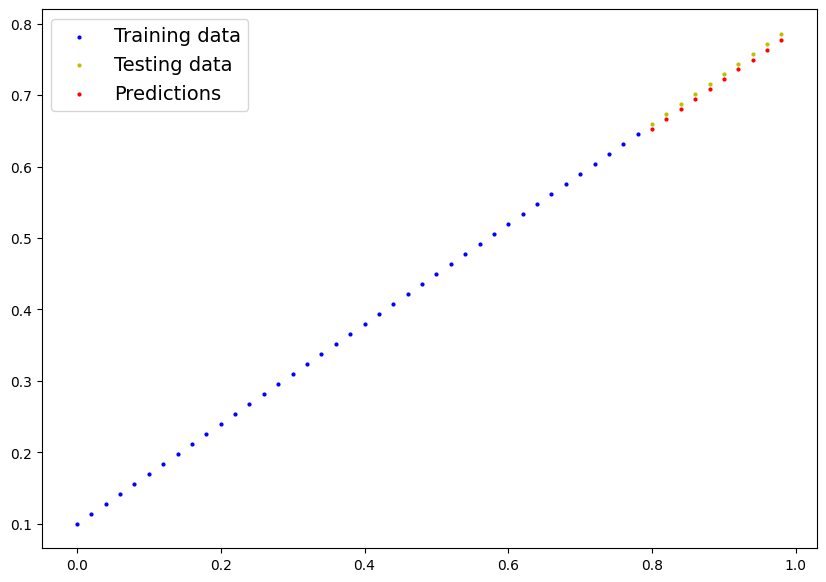

In [111]:
plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test, predictions=test_pred)

In [117]:
loaded_model_1 = LinearRegressionModelV2()
loaded_model_1.load_state_dict(torch.load(MODEL_HOME / "02_pytorch_linear.pth", weights_only=True))
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6919]])),
             ('linear_layer.bias', tensor([0.0995]))])

In [122]:
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)
loaded_model_1_preds, test_pred, test_pred == loaded_model_1_preds

(tensor([[0.6531],
         [0.6669],
         [0.6807],
         [0.6946],
         [0.7084],
         [0.7223],
         [0.7361],
         [0.7499],
         [0.7638],
         [0.7776]]),
 tensor([[0.6531],
         [0.6669],
         [0.6807],
         [0.6946],
         [0.7084],
         [0.7223],
         [0.7361],
         [0.7499],
         [0.7638],
         [0.7776]]),
 tensor([[True],
         [True],
         [True],
         [True],
         [True],
         [True],
         [True],
         [True],
         [True],
         [True]]))